In [1]:
import pyspark
import os.path

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from getpass import getpass
import pandas as pd
import pickle
conf = pyspark.SparkConf().setAll([('spark.app.name', 'Spark Data Exploration')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

conf.getAll()

2.3.2
<module 'pyspark.version' from '/usr/local/lib/python3.6/dist-packages/pyspark/version.py'>


dict_items([('spark.app.name', 'Spark Data Exploration')])

In [2]:
prA_fpath = 'full_table_new.csv'
dfa = spark.read.csv(prA_fpath,inferSchema=True,header=True)
rows_countsA = dfa.count()
print(rows_countsA)

118318


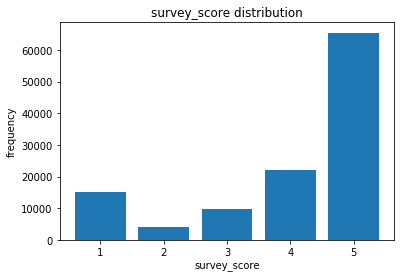

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

data = pd.read_csv('full_table_new.csv')
data = data.dropna()
# survey_score stastics and distribution
data['survey_score'].describe()
# survey_score stastics and distribution
data['survey_score'].describe()
# survey_score distribution 
ratings = list(Counter(data['survey_score']).keys()) # get all unique ratings
frequency = list(Counter(data['survey_score']).values()) # count the number of each rating
plt.bar(ratings,frequency)
plt.title('survey_score distribution')
plt.xlabel('survey_score')
plt.ylabel('frequency')
plt.show()



In [ ]:
# average payment value in different survey_score
a = data.groupby('survey_score').mean()['payment_value'].sort_values()
plt.barh(a.index,a)
plt.title('average payment value in different survey_score')
plt.xlabel('payment value')
plt.ylabel('survey_score')
plt.show()


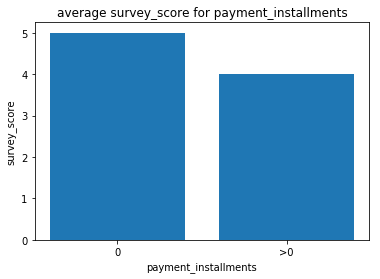

In [5]:
#### payment_installments 
data['payment_install'] = ['0' if i < 1 else '>0' for i in  data['payment_installments']]
a = data.groupby('payment_install').mean()['survey_score']
plt.bar(a.index,a)
plt.title('average survey_score for payment_installments')
plt.xlabel('payment_installments')
plt.ylabel('survey_score')
plt.show()

In [3]:
dfa.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- survey_send_date: string (nullable = true)
 |-- survey_completion_date: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- order_status: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_photos_qty: string (nullable = true)
 |-- product_weight_g: string (nullable = true)
 |-- product_length_cm: string (nullable = true)
 |-- product_height_cm: string (nullable = true)
 |-- product_width_cm: string (nullable = true)
 |-- product_category_name_english

In [3]:
#change data type
from pyspark.sql.types import IntegerType,DoubleType
dfa = dfa.withColumn("price", dfa["price"].cast(IntegerType()))
dfa = dfa.withColumn("freight_value", dfa["freight_value"].cast(IntegerType()))
dfa = dfa.withColumn("payment_installments", dfa["payment_installments"].cast(IntegerType()))
dfa = dfa.withColumn("payment_value", dfa["payment_value"].cast(IntegerType()))
dfa = dfa.withColumn("product_weight_g", dfa["product_weight_g"].cast(IntegerType()))
dfa = dfa.withColumn("product_length_cm", dfa["product_length_cm"].cast(IntegerType()))
dfa = dfa.withColumn("product_height_cm", dfa["product_height_cm"].cast(IntegerType()))
dfa = dfa.withColumn("product_width_cm", dfa["product_width_cm"].cast(IntegerType()))
dfa = dfa.withColumn("survey_score", dfa["survey_score"].cast(IntegerType()))

In [4]:
col= dfa.columns
col = col[:-1]
dfa_new = dfa.na.drop(subset=col)

In [5]:
#one hot encoding 
import pyspark.sql.functions as F
featureCols = [
 'price',
 'freight_value',
'payment_installments',
 'payment_value',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'survey_score']
types_order = dfa_new.select('order_status').distinct().rdd.flatMap(lambda x: x).collect()
types_orde = [F.when(F.col("order_status") == ty, 1).otherwise(0).alias("order_status_" + ty) for ty in types_order]
types_customer = dfa_new.select('customer_state').distinct().rdd.flatMap(lambda x: x).collect()
types_cust = [F.when(F.col("customer_state") == cs, 1).otherwise(0).alias("customer_state_" + cs) for cs in types_customer]
types_state = dfa_new.select('seller_state').distinct().rdd.flatMap(lambda x: x).collect()
types_sta = [F.when(F.col("seller_state") == ss, 1).otherwise(0).alias("seller_state_" + ss) for ss in types_state]
dfa_new = dfa_new.select('price',
 'freight_value',
'payment_installments',
 'payment_value',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'survey_score',*types_orde+types_cust+types_sta)


In [6]:
#cleaning NA data 
dfa_test = dfa_new.filter('survey_score is NULL')
dfa_train =  dfa_new.subtract(dfa_test)
print(dfa_new.count(),dfa_train.count(),dfa_test.count())

116605 98210 5


In [7]:
#balancing data
dfa_use = dfa_train.filter('survey_score == 5')
dfa_use_left =  dfa_train.subtract(dfa_use)
actual_number  = dfa_train.filter('survey_score == 5').count()
balance_number = dfa_train.filter('survey_score == 4').count()
actual_number_1 =dfa_train.filter('survey_score == 1').count()
actual_number_2 =dfa_train.filter('survey_score == 2').count()
actual_number_3 =dfa_train.filter('survey_score == 3').count()
dfa_5 = dfa_use.sample(True, balance_number/actual_number, 1234)
dfa_1 = dfa_train.filter('survey_score == 1').sample(True,balance_number/actual_number_1,1234)
dfa_2 = dfa_train.filter('survey_score == 2').sample(True,balance_number/actual_number_2,1234)
dfa_3 = dfa_train.filter('survey_score == 3').sample(True,balance_number/actual_number_3,1234)
dfa_4 = dfa_train.filter('survey_score == 4')
dfa_train_merge= dfa_1.union(dfa_2).union(dfa_3).union(dfa_4).union(dfa_5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60f5573ac8>]],
      dtype=object)

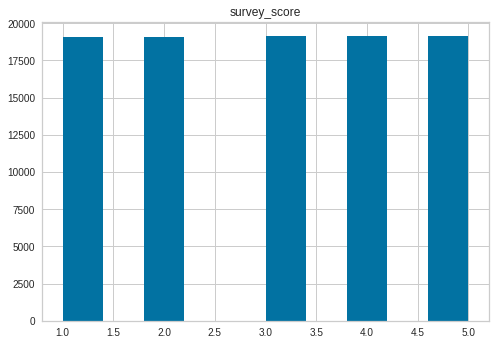

In [54]:
#plot
dfa_train_merge.select('survey_score') .toPandas().hist()

In [8]:
#create bin based on low,medium,high score
from pyspark.ml.feature import Bucketizer


splits=[0,2.5,3.5,5]

bucketizer = Bucketizer(splits=splits, inputCol="survey_score", outputCol="bucketedFeatures")

# Transform original data into its bucket index.
bucketedData = bucketizer.transform(dfa_train_merge)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
bucketedData=bucketedData.drop('survey_score')

bucketedData.describe('bucketedFeatures').show()
bucketedData.printSchema()

Bucketizer output with 3 buckets
+-------+------------------+
|summary|  bucketedFeatures|
+-------+------------------+
|  count|             95576|
|   mean|1.0007324014396919|
| stddev|0.8942982041044789|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+

root
 |-- price: integer (nullable = true)
 |-- freight_value: integer (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)
 |-- order_status_shipped: integer (nullable = false)
 |-- order_status_canceled: integer (nullable = false)
 |-- order_status_approved: integer (nullable = false)
 |-- order_status_invoiced: integer (nullable = false)
 |-- order_status_delivered: integer (nullable = false)
 |-- order_status_unavailable: integer (null

In [55]:
#create 5 bins according to the raw data
from pyspark.ml.feature import Bucketizer


splits=[0,1.5,2.5,3.5,4.5,5]

bucketizer = Bucketizer(splits=splits, inputCol="survey_score", outputCol="bucketedFeatures")

# Transform original data into its bucket index.
bucketedData5 = bucketizer.transform(dfa_train_merge)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
bucketedData5=bucketedData5.drop('survey_score')

bucketedData5.describe('bucketedFeatures').show()

Bucketizer output with 5 buckets
+-------+------------------+
|summary|  bucketedFeatures|
+-------+------------------+
|  count|             95576|
|   mean|2.0010672135264085|
| stddev|1.4137321785648105|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



In [56]:
#5 class prediction using RDD randomforest
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

transformed_df5 = bucketedData5.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))

splits = [0.6, 0.4]
training_data5, test_data5 = transformed_df5.randomSplit(splits, 1234)



In [57]:
from pyspark.mllib.tree import RandomForest
from time import *

start_time = time()

model5 = RandomForest.trainClassifier(training_data5,numClasses= 5 ,categoricalFeaturesInfo={}, \
    numTrees=20, featureSubsetStrategy="auto", maxDepth=15, seed=1234)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 1021.641 seconds


In [60]:
predictions5 = model5.predict(test_data5.map(lambda x: x.features))
labels_and_predictions5 = test_data5.map(lambda x: x.label).zip(predictions5)
acc5 = labels_and_predictions5.filter(lambda x: x[0] == x[1]).count() / float(test_data5.count())
print("Model accuracy: %.3f%%" % (acc5 * 100))
dff5= labels_and_predictions5.toDF()

Model accuracy: 32.540%


Confusion matrix, without normalization
[[2595 1091 1270 1027 1568]
 [ 855 2870 1297  981 1575]
 [ 987  932 2478 1293 1919]
 [ 849  984 1724 1633 2536]
 [ 809  919 1627 1557 2869]]


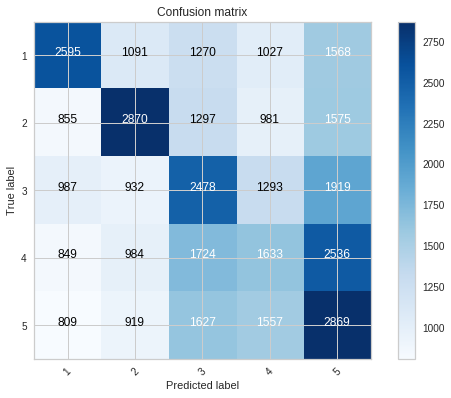

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.pyplot

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



yTrue5 = dff5.select("_1").toPandas()
yPred5 = dff5.select('_2').toPandas()
cnfMatrix5 = confusion_matrix(yTrue5, yPred5)
plot_confusion_matrix(cnfMatrix5,'12345',normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

In [9]:
#balancing 3 - bins data
actual_number_1 =bucketedData.filter('bucketedFeatures == 1').count()
actual_number_2 =bucketedData.filter('bucketedFeatures == 2').count()
dfa_1_new = bucketedData.filter('bucketedFeatures == 1').sample(True,actual_number_2/actual_number_1,1234)
dfa_0_new = bucketedData.filter('bucketedFeatures == 0')
dfa_2_new = bucketedData.filter('bucketedFeatures == 2')
bucketedData_merge= dfa_1_new.union(dfa_0_new).union(dfa_2_new)
bucketedData_merge.select('bucketedFeatures') .toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f27f148b4e0>]],
      dtype=object)

In [10]:
featureCols =bucketedData_merge.columns
featureCols.remove('bucketedFeatures')

In [11]:
#3 classes prediciton model using RDD
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

transformed_df = bucketedData_merge.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))

splits = [0.7, 0.3]
training_data, test_data = transformed_df.randomSplit(splits, 1234)

print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 80727
Number of test set rows: 34461


In [12]:
from pyspark.mllib.tree import RandomForest
from time import *

start_time = time()

model = RandomForest.trainClassifier(training_data,numClasses= 3 ,categoricalFeaturesInfo={}, \
    numTrees=20, featureSubsetStrategy="auto", maxDepth=15, seed=1234)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 3145.311 seconds


In [13]:
predictions = model.predict(test_data.map(lambda x: x.features))
labels_and_predictions = test_data.map(lambda x: x.label).zip(predictions)


In [14]:
acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())
print("Model accuracy: %.3f%%" % (acc * 100))

Model accuracy: 50.840%


In [15]:
dff= labels_and_predictions.toDF()

Confusion matrix, without normalization
[[4778 2848 3790]
 [1278 6574 3734]
 [1715 3576 6168]]


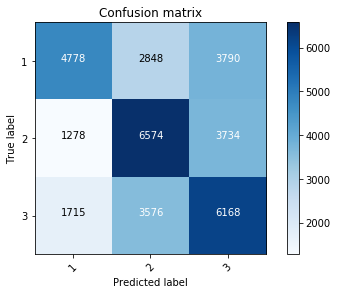

In [16]:


yTrue = dff.select("_1").toPandas()
yPred = dff.select('_2').toPandas()
cnfMatrix = confusion_matrix(yTrue, yPred)
plot_confusion_matrix(cnfMatrix,'123',normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

Normalized confusion matrix
[[0.41853539 0.24947442 0.33199019]
 [0.11030554 0.56740894 0.32228552]
 [0.14966402 0.31206912 0.53826686]]


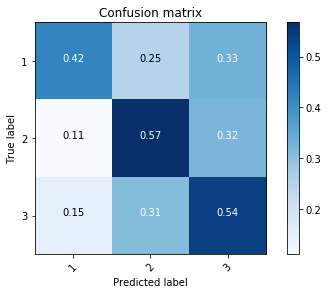

In [17]:
plot_confusion_matrix(cnfMatrix,'123',normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)

In [12]:
#3 class prediction model using RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
labelCol = "bucketedFeatures"
indexedCol = '{}Indexed'.format(labelCol)
indexedDf = StringIndexer(inputCol=labelCol, outputCol=indexedCol).fit(bucketedData_merge).transform(bucketedData_merge)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")# handleInvalid="skip")
data = assembler.transform(indexedDf)[['features', labelCol, indexedCol]]
trainDf1, testDf1 = data.randomSplit([0.75, 0.25], seed=1234)
trainDf1.show(5)


+--------------------+----------------+-----------------------+
|            features|bucketedFeatures|bucketedFeaturesIndexed|
+--------------------+----------------+-----------------------+
|(65,[0,1,2,3,4,5,...|             1.0|                    0.0|
|(65,[0,1,2,3,4,5,...|             1.0|                    0.0|
|(65,[0,1,2,3,4,5,...|             1.0|                    0.0|
|(65,[0,1,2,3,4,5,...|             1.0|                    0.0|
|(65,[0,1,2,3,4,5,...|             1.0|                    0.0|
+--------------------+----------------+-----------------------+
only showing top 5 rows



In [44]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'bucketedFeatures',numTrees=20)
rfModel = rf.fit(trainDf1)

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predrf = rfModel.transform(testDf1)
evaluator = MulticlassClassificationEvaluator(
    labelCol='bucketedFeatures', predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predrf)
print("Test Acc = %g " % (accuracy))


Test Acc = 0.407072 


Confusion matrix, without normalization
[[3380 3186 2924]
 [1945 3923 3844]
 [1785 3419 4439]]


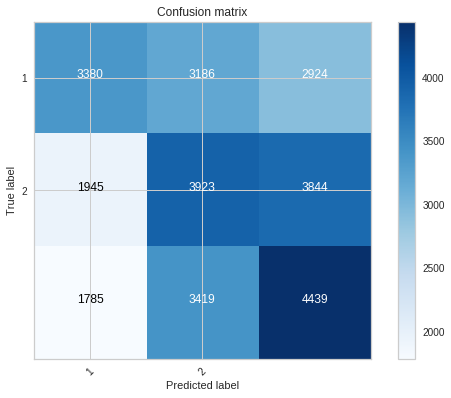

In [47]:
from sklearn.metrics import confusion_matrix

labelCol = "bucketedFeatures"
classes = predrf.select(labelCol).groupBy(labelCol)\
                        .count().sort('count', ascending=False).toPandas()
classLabels = classes[labelCol].values.tolist()



yTrue = predrf.select("bucketedFeatures").toPandas()
yPred = predrf.select('prediction').toPandas()
cnfMatrix = confusion_matrix(yTrue, yPred)
plot_confusion_matrix(cnfMatrix,'12',normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

Normalized confusion matrix
[[0.35616438 0.33572181 0.3081138 ]
 [0.20026771 0.40393328 0.39579901]
 [0.18510837 0.35455771 0.46033392]]


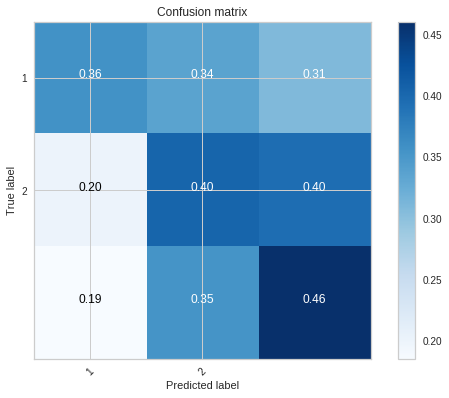

In [48]:
plot_confusion_matrix(cnfMatrix,'12',normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier

treeModel = DecisionTreeClassifier(labelCol='bucketedFeatures', featuresCol= 'features',maxDepth=20)

# Fit the model
modelTuning = treeModel.fit(trainDf1)
print(modelTuning)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4fc982a206895212929f) of depth 20 with 15085 nodes


In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predDf = modelNoTuning.transform(testDf1)

evaluator = MulticlassClassificationEvaluator(
    labelCol='bucketedFeatures', predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDf)
print("Test Acc = %g " % (accuracy))



Test Acc = 0.642919 


In [28]:
modelTuning.featureImportances

SparseVector(65, {0: 0.1391, 1: 0.1467, 2: 0.0929, 3: 0.0875, 4: 0.1064, 5: 0.0888, 6: 0.0858, 7: 0.074, 8: 0.0008, 9: 0.0002, 11: 0.0005, 12: 0.0332, 15: 0.007, 16: 0.0013, 17: 0.002, 18: 0.0009, 19: 0.0003, 20: 0.0048, 21: 0.0014, 22: 0.0026, 23: 0.0125, 24: 0.0052, 25: 0.0023, 26: 0.0082, 27: 0.0021, 28: 0.0018, 29: 0.0106, 30: 0.0034, 31: 0.0091, 32: 0.0011, 33: 0.0034, 34: 0.0038, 35: 0.0013, 36: 0.0064, 37: 0.0023, 38: 0.0006, 39: 0.0056, 40: 0.0084, 41: 0.0006, 42: 0.0036, 43: 0.0004, 46: 0.0006, 47: 0.0005, 48: 0.0078, 49: 0.0003, 50: 0.0001, 51: 0.0017, 52: 0.0001, 53: 0.0049, 55: 0.0005, 56: 0.0001, 57: 0.0005, 58: 0.0003, 60: 0.0044, 61: 0.0005, 63: 0.0021, 64: 0.0064})

Confusion matrix, without normalization
[[6067 1780 1643]
 [ 675 7516 1521]
 [1880 2801 4962]]


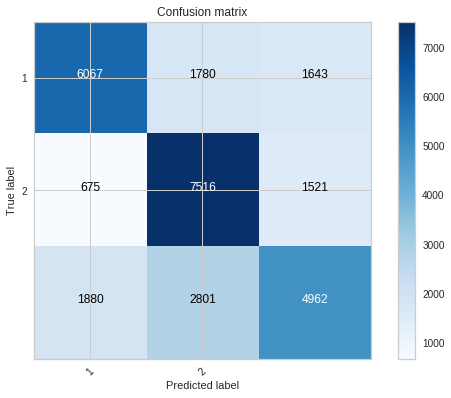

In [41]:
from sklearn.metrics import confusion_matrix

labelCol = "bucketedFeatures"
classes = predDf.select(labelCol).groupBy(labelCol)\
                        .count().sort('count', ascending=False).toPandas()
classLabels = classes[labelCol].values.tolist()



yTrue = predDf.select("bucketedFeatures").toPandas()
yPred = predDf.select('prediction').toPandas()
cnfMatrix = confusion_matrix(yTrue, yPred)
plot_confusion_matrix(cnfMatrix,'12',normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

Normalized confusion matrix
[[0.63930453 0.18756586 0.17312961]
 [0.06950165 0.77388797 0.15661038]
 [0.19496007 0.29046977 0.51457015]]


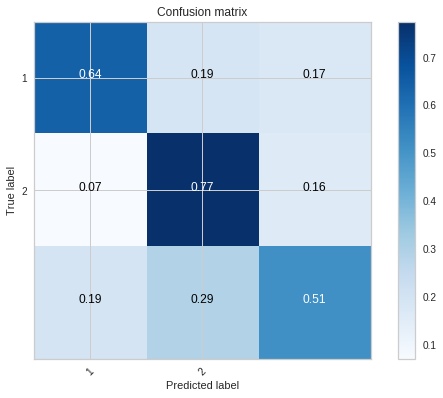

In [42]:
plot_confusion_matrix(cnfMatrix,'12',normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)